In [13]:
%load_ext autoreload
%autoreload 2

from datasets import DataCocoFeat
from models import LSTMCaption
from optimers import OptimerAdam
from utils import check_gradient, show_training_info
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# load data
dataloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=True)
dataloader.show_info()

Training data shape:  (400135, 512)
Training labels shape:  (400135, 17)
Validation data shape:  (195954, 512)
Validation labels shape:  (195954, 17)
Number of training images:  82783
Number of validation images:  40504
Number of words:  1004


In [15]:
def test_model(model, data, idx_train, idx_val):
    caps_train = model.predict(data.x_train[idx_train])
    caps_val = model.predict(data.x_val[idx_val])

    # the predicted captions
    for i in range(len(caps_train)):
        print('Predicted training data:', data.decode_captions(caps_train[i]))
        data.show_by_index(idx_train[i], data_type='train')

    for i in range(len(caps_val)):
        print('Predicted validation data:', data.decode_captions(caps_val[i]))
        data.show_by_index(idx_val[i], data_type='val')

# Sanity check

### Init loss

In [16]:
def get_init_model(hyperparams):
    return LSTMCaption(512, None, hyperparams=hyperparams, seed=100)

# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 32, 'num_vector': 32, 'init_scale': None})

# init loss
loss = model.backward(dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])
print('Sanity check result:')
print('Init loss is', loss)

Sanity check result:
Init loss is 74.95799348737717


### Gradient check

In [17]:
# gradient check
for i in range(3):
    print('\nGradient check result - ', i + 1, ':')
    check_gradient(model, dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])


Gradient check result -  1 :
Layer | Key | Numerical gradient | Calculated gradient | Relative error
<class 'models.layers.layers.Linear'> W -0.02281458932884561 -0.022814591363350446 8.91756023041319e-08
<class 'models.layers.layers.Linear'> b -0.00027476474429022346 -0.00027476512518263916 1.3862482709574286e-06
<class 'models.layers.rnn_layers.WordEmbedding'> W_embed 0.0 0.0 nan
<class 'models.layers.rnn_layers.LSTM'> Wx -0.001269894056576959 -0.0012698942416403194 1.4573132776406334e-07
<class 'models.layers.rnn_layers.LSTM'> Wh 0.0007224628006952115 0.0007224625800277805 3.0543782259613305e-07
<class 'models.layers.rnn_layers.LSTM'> b 0.004841768230789967 0.004841768532254377 6.226328607734397e-08
<class 'models.layers.rnn_layers.LinearForRNN'> W 1.8150103642256e-05 1.8149779281561744e-05 1.787117026994973e-05
<class 'models.layers.rnn_layers.LinearForRNN'> b 0.010988973286885083 0.010988974433190416 1.0431413781130408e-07

Gradient check result -  2 :
Layer | Key | Numerical gra

### Overfit small dataset

In [18]:
# load small dataset
smallloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=True,
                           num_train=64, num_val=64, order_by='random')

# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 512, 'num_vector': 256})

# train model
optimer = OptimerAdam({'learn_rate': 5e-3, 'learn_rate_decay': 0.995, 'num_iters': 200, 'batch_size': 32}, 
                      print_every=10, check_val_acc=False, check_train_acc=False)

optimer.train(model, smallloader)

# save model
model.save('./saves/LSTMCaption/model_small.pkl')

0 / 200 loss is 78.83711649693159
10 / 200 loss is 55.167943516834804
20 / 200 loss is 45.658217440134216
30 / 200 loss is 36.34928401123207
40 / 200 loss is 27.80470191477672
50 / 200 loss is 15.17383547120226
60 / 200 loss is 7.709038086859929
70 / 200 loss is 3.856457928210394
80 / 200 loss is 1.9719956750997127
90 / 200 loss is 0.836722598666969
100 / 200 loss is 0.6237353903939975
110 / 200 loss is 0.3592012761129137
120 / 200 loss is 0.26720248556007664
130 / 200 loss is 0.15723672448437623
140 / 200 loss is 0.14143132110020656
150 / 200 loss is 0.10574514727021872
160 / 200 loss is 0.08635335106694247
170 / 200 loss is 0.0856322366621377
180 / 200 loss is 0.07902113241404202
190 / 200 loss is 0.06415744502951834


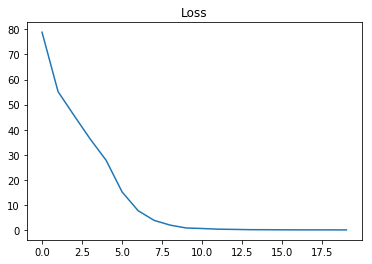

In [21]:
# plot loss curve
show_training_info(optimer)

Predicted training data: <START> a person <UNK> with a snowboard that is <UNK> <END>


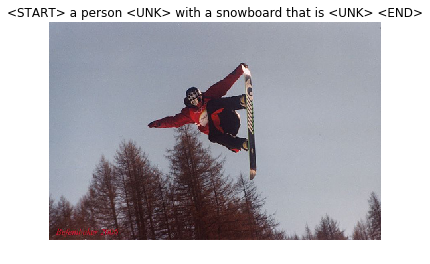

Predicted training data: <START> two <UNK> elephants look <UNK> toward their <UNK> <END>


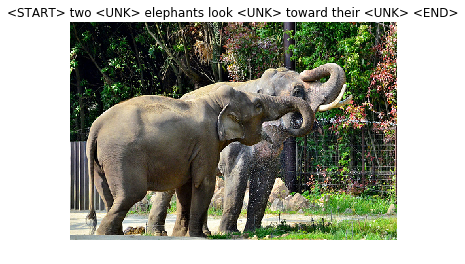

Predicted training data: <START> a sheep standing on top of a hay <UNK> <END>


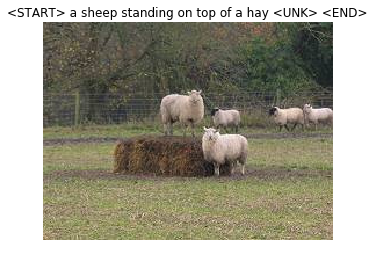

Predicted validation data: <START> man is <UNK> his skateboard tricks <END>


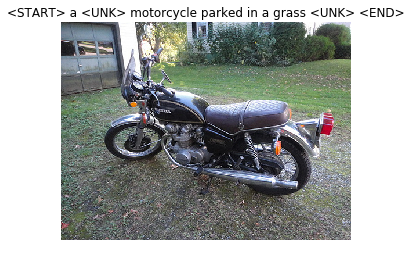

Predicted validation data: <START> a flat screen tv in front of a fire place next to a window <END>


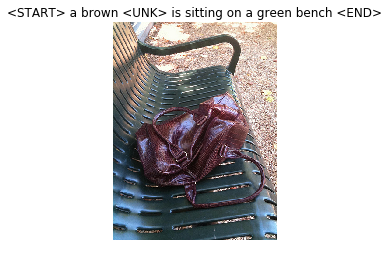

Predicted validation data: <START> a boy in the middle of doing a <UNK> <UNK> on a skate board <END>


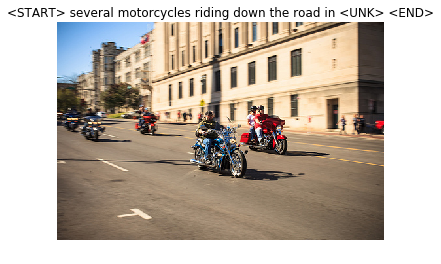

In [22]:
# load model
model = LSTMCaption.load('./saves/LSTMCaption/model_small.pkl')

# test model
test_model(model, smallloader, [0, 1, 3], [0, 1, 2])

# Train LSTM-Caption model

### Train Model

In [24]:
# init model
if True:
    model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                            'reg': 0.01, 'num_hidden': 1024, 'num_vector': 512})
else:
    model = LSTMCaption.load('./saves/LSTMCaption/model.pkl')

# train model 'learn_rate': 2e-3
optimer = OptimerAdam({'learn_rate': 2e-3, 'learn_rate_decay': 0.995, 'num_iters': 2000, 'batch_size': 256}, 
                      print_every=100, check_val_acc=False, check_train_acc=False)

optimer.train(model, dataloader)

# save model
model.save('./saves/LSTMCaption/model.pkl')

0 / 2000 loss is 78.91819101916197
100 / 2000 loss is 39.07708272164327
200 / 2000 loss is 36.74248412015572
300 / 2000 loss is 35.2338489526818
400 / 2000 loss is 33.97543448398109
500 / 2000 loss is 32.758945615801366
600 / 2000 loss is 31.652986210241018
700 / 2000 loss is 32.69839308676408
800 / 2000 loss is 31.78744018012674
900 / 2000 loss is 31.388592374370855
1000 / 2000 loss is 33.19895236836393
1100 / 2000 loss is 32.81974527000384
1200 / 2000 loss is 32.395271972393964
1300 / 2000 loss is 32.349465654265316
1400 / 2000 loss is 31.74913027615841
1500 / 2000 loss is 31.94477695286135
1600 / 2000 loss is 30.870892829229835
1700 / 2000 loss is 29.955059075439806
1800 / 2000 loss is 30.300000505286118
1900 / 2000 loss is 30.634365727740708


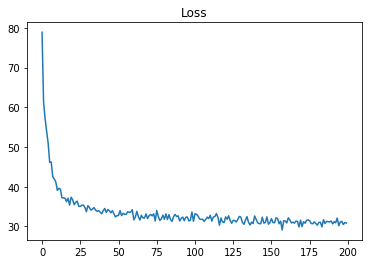

In [25]:
# plot loss curve
show_training_info(optimer)

Predicted training data: <START> a bathroom with a toilet and a sink <END>


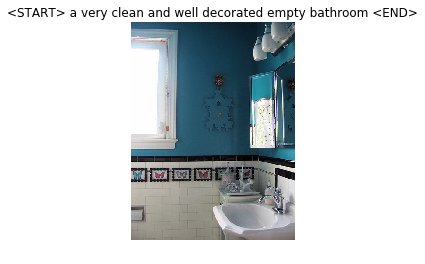

Predicted training data: <START> a man sitting on a couch with a remote control <END>


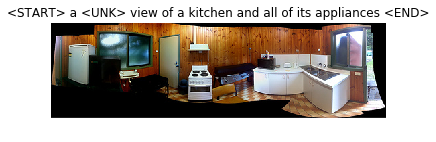

Predicted training data: <START> a stop sign is <UNK> on a pole <END>


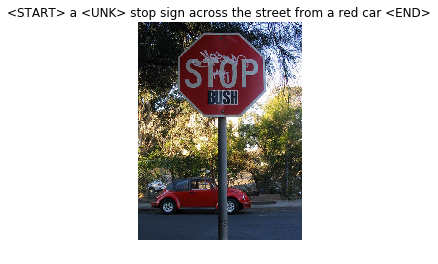

Predicted validation data: <START> a <UNK> truck parked on the side of a road <END>


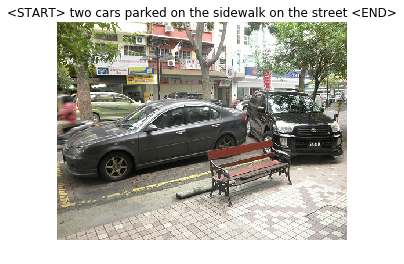

Predicted validation data: <START> a large plane flying through the sky <END>


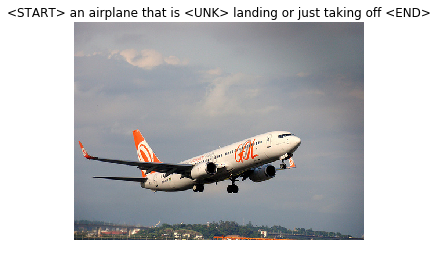

Predicted validation data: <START> a bathroom with a toilet and a sink <END>


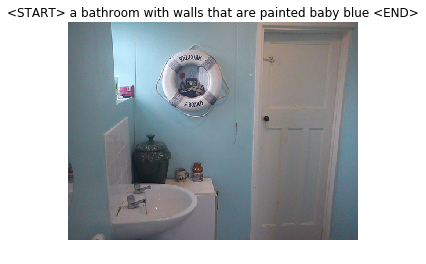

Predicted validation data: <START> a bathroom with a toilet and a sink <END>


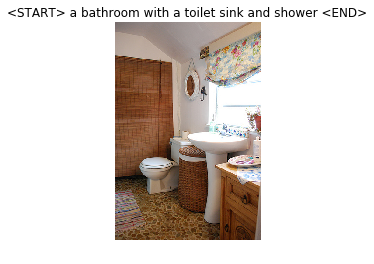

Predicted validation data: <START> a kitchen with a <UNK> <UNK> and a <UNK> <END>


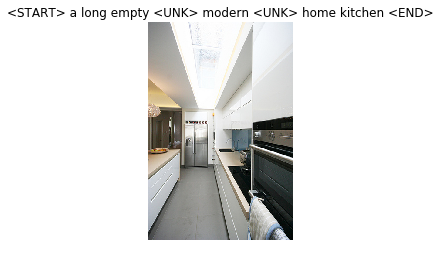

Predicted validation data: <START> a man and woman are sitting on a bench <END>


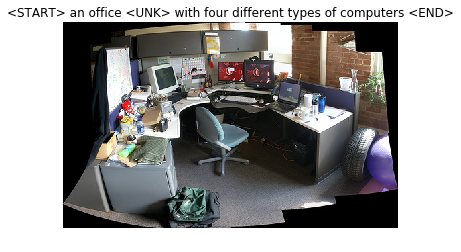

In [28]:
# load model
model = LSTMCaption.load('./saves/LSTMCaption/model.pkl')

# test model
test_model(model, dataloader, [0, 1, 4], [10, 11, 12, 13, 14, 15])